# Indicadores de Clientes e Segmentação de Clientes por perfil de carteira de fundos de invesimentos  


## Contexto

Supondo uma empresa atacadista (Cedente) realizando transações de títulos dos fundos com os seus clientes (Sacado), de modo que os títulos têm: valor, taxa de juros mensal, taxa de desagio, uma data de vencimento e uma data de pagamento.

Apresentamos alguns indicadores do comportamento dos clientes atuantes nas transações e também uma Segmentação dos clientes por perfil com algoritmo de machine learning não-supervisionado K-means.

Na implementação da análise utilizamos a linguagem Python, com o aparato das bibliotecas: Pandas, Numpy, Matplotlib, Seaborn, Sklearn-KMeans.



A Base de dados possui valores fictícios, de modo que têm as colunas abaixo:

| Nome variável | Descrição da variável |
| ------ | ------ |
| CODIGO | Código do título |
| NOME_FUNDO | Nome do fundo em que o título está registrado|
| TIPO_PRODUTO | Tipo de produto do título |
| CEDENTE | Nome do Cedente |
| SACADO | Nome do sacado |
| LIMITE_CEDENTE | Limite de Crédito do Cedente |
| ESTADO_CEDENTE | Estado de cadastro do Cedente |
| ESTADO_SACADO | Estado de cadastro do sacado |
| VENCIMENTO | Data de vencimento do título |
| DATA_EMISSAO | Data de emissão do título |
| DATA_PAGAMENTO | Data de vencimento de pagamento do título |
| VALOR_REAL | Valor do título |
| VALOR_DESAGIO | valor de deságio do título |
| TAXA_MENSAL | Taxa mensal (30 dias) que foi utilizada para o desconto do título |
| STATUS_LIQ_TITULO | Status de liquidação do título (EM_DIA: O Título foi pago em dia, ATRASO o título foi pago em atraso) |

# Implementação

Vamos iniciar a nossa análise!

# Coletados Dados

## Imports básicos


In [1]:
!pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Coleta de Dados


In [3]:
df_titulos = pd.read_csv("BASE_TITULOS.txt", sep="\t")
df_titulos.head()

,CODIGO,NOME_FUNDO,TIPO_PRODUTO,CEDENTE,SACADO,LIMITE_CEDENTE,ESTADO_CEDENTE,ESTADO_SACADO,VENCIMENTO,DATA_EMISSAO,...,RISCO_13,RISCO_14,RISCO_15,RISCO_16,RISCO_17,RISCO_18,RISCO_19,RISCO_20,RISCO_21,STATUS_LIQ_TITULO
0,1,Fundo 1,Produto 1,Cedente 2,Sacado 249,10000000,CE,SP,2018-03-18,2017-10-28,...,0.168124,0,0.066667,0.2,0.727965,0.738669,0.407407,0.860111,0.985155,EM_DIA
1,2,Fundo 2,Produto 1,Cedente 1,Sacado 1372,8035714,PA,MG,2018-06-24,2018-05-21,...,0.392065,0,0.266667,0.6,0.010041,0.012547,0.395062,0.698438,0.707374,EM_DIA
2,3,Fundo 1,Produto 1,Cedente 2,Sacado 346,10000000,CE,PR,2018-03-19,2017-11-29,...,0.109617,0,0.066667,0.2,0.327489,0.321123,0.395062,0.890059,0.987560,ATRASO
3,4,Fundo 2,Produto 1,Cedente 1,Sacado 585,8035714,PA,PA,2018-04-03,2018-02-14,...,0.415602,0,0.400000,0.6,0.012217,0.017485,0.419753,0.609827,0.906279,ATRASO
4,5,Fundo 1,Produto 1,Cedente 2,Sacado 2184,10000000,CE,RJ,2018-02-02,2017-11-03,...,0.168124,0,0.066667,0.2,0.727965,0.738669,0.407407,0.860111,0.368493,EM_DIA


# Indicadores dos clientes cedentes 

### Indicador de Taxa de Pagamento por Cliente Cedente

In [4]:
# criando um novo dataFrame com dados dos cedentes - quantidade de pagamentos em dia e com atraso
df_indicadores_cedentes = df_titulos.groupby(['CEDENTE', 'STATUS_LIQ_TITULO'])['CODIGO'].agg(['count']).reset_index()
df_indicadores_cedentes.head()

,CEDENTE,STATUS_LIQ_TITULO,count
0,Cedente 1,ATRASO,166
1,Cedente 1,EM_DIA,1335
2,Cedente 10,ATRASO,4
3,Cedente 10,EM_DIA,46
4,Cedente 11,ATRASO,18


In [5]:
# ATRASO e EM_DIA estão como linhas - queremos que sejam colunas
# vamos pivotar as linhas de STATUS_LIQ_TITULO como colunas 'EM_DIA' e 'ATRASO' 
df_indicadores_cedentes = pd.pivot(df_indicadores_cedentes,
                                  columns=['STATUS_LIQ_TITULO'],
                                  values='count', index='CEDENTE').reset_index() 
df_indicadores_cedentes.head()  

STATUS_LIQ_TITULO,CEDENTE,ATRASO,EM_DIA
0,Cedente 1,166,1335
1,Cedente 10,4,46
2,Cedente 11,18,86
3,Cedente 12,4,103
4,Cedente 13,17,35


In [6]:
# calculando a taxa de pagamento por cedente e o numero total de titulos por cedente
df_indicadores_cedentes['TOTAL_TITULOS'] = df_indicadores_cedentes['ATRASO'] + df_indicadores_cedentes['EM_DIA']
df_indicadores_cedentes['TAXA_PAGAMENTO_TITULOS'] = round(df_indicadores_cedentes['EM_DIA'] /  df_indicadores_cedentes['TOTAL_TITULOS'], 2)

In [7]:
# taxa de pagamento média entre cedentes
media_taxa_pagamento = 100*round(df_indicadores_cedentes.TAXA_PAGAMENTO_TITULOS.mean(), 3)
print(f"Taxa de Pagamento média dos clientes cedentes: {media_taxa_pagamento}%")

Taxa de Pagamento média dos clientes cedentes: 74.7%


In [8]:
df_indicadores_cedentes[['CEDENTE', 'TOTAL_TITULOS', 'TAXA_PAGAMENTO_TITULOS']].sort_values(by='TAXA_PAGAMENTO_TITULOS', ascending=False)

STATUS_LIQ_TITULO,CEDENTE,TOTAL_TITULOS,TAXA_PAGAMENTO_TITULOS
3,Cedente 12,107,0.96
19,Cedente 5,385,0.93
1,Cedente 10,50,0.92
22,Cedente 8,150,0.91
23,Cedente 9,976,0.90
0,Cedente 1,1501,0.89
10,Cedente 19,459,0.88
16,Cedente 24,382,0.88
5,Cedente 14,181,0.87
21,Cedente 7,22,0.86


Vemos que o cliente com a maior taxa de Pagamento é o Cedente 12.

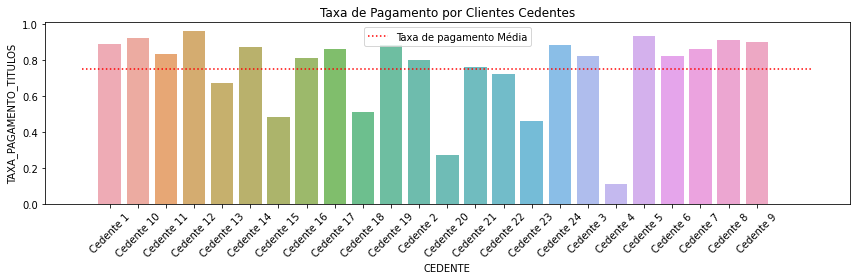

In [9]:
plt.figure(figsize=(12,4))

sns.barplot(x=df_indicadores_cedentes.CEDENTE, 
            y=df_indicadores_cedentes.TAXA_PAGAMENTO_TITULOS, 
            alpha=0.8)
plt.title('Taxa de Pagamento por Clientes Cedentes')
plt.hlines(df_indicadores_cedentes.TAXA_PAGAMENTO_TITULOS.mean(),-1, 25,color='r',linestyles=':', 
           label='Taxa de pagamento Média')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Neste gráfico temos uma visão dos clientes cedentes com taxas de pagamento acima e abaixo da média.

### Indicador de receita gerada por clientes credentes

In [10]:
# armazenando dados da receita por cliente cedente em um novo DataFrame
df_receita_cedente = df_titulos.groupby('CEDENTE')['VALOR_REAL'].agg(['sum']).reset_index()

In [11]:
# renomeando nome da coluna
df_receita_cedente = df_receita_cedente.rename(columns={'sum':'RECEITA'})

In [12]:
# receita média dos cedentes
media_receita = round(df_receita_cedente.RECEITA.mean(), 2)
print(f"Receita média dos clientes cedentes: R${media_receita}")

Receita média dos clientes cedentes: R$2524006.96


In [117]:
display(df_receita_cedente.sort_values(by='RECEITA', ascending=False))

,CEDENTE,RECEITA
0,Cedente 1,10280760.20
17,Cedente 3,9011644.10
4,Cedente 13,5329983.11
23,Cedente 9,4987095.02
11,Cedente 2,4639191.77
1,Cedente 10,4191119.98
2,Cedente 11,3559953.22
10,Cedente 19,3129771.15
16,Cedente 24,3044420.31
21,Cedente 7,1710127.21


O cliente cedente com maior receita gerada é o Cedente 1


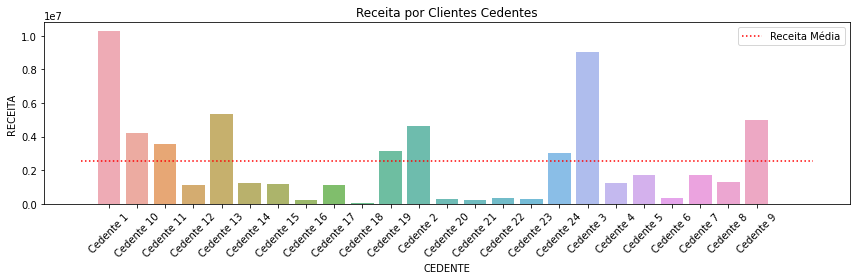

In [13]:
plt.figure(figsize=(12,4))

sns.barplot(x=df_receita_cedente.CEDENTE, 
            y=df_receita_cedente.RECEITA, 
            alpha=0.8)
plt.title('Receita por Clientes Cedentes')
plt.hlines(df_receita_cedente.RECEITA.mean(),-1, 25,color='r',linestyles=':', label='Receita Média')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


A maior parte dos clientes cedentes tem receitas abaixo da média. Vemos que poucos clientes cedentes geraram receitas mais altas, e por isso o valor da média foi maior. 

### Visão Geral dos indicadores por Cedentes

In [14]:
# unificando coluna de receita no dataframe com os outros indicadores de cedentes
df_indicadores_cedentes = pd.merge(df_indicadores_cedentes, 
                         df_receita_cedente, 
                         on=['CEDENTE'])


In [16]:
display(df_indicadores_cedentes.sort_values(by='RECEITA', ascending=False).head())

,CEDENTE,ATRASO,EM_DIA,TOTAL_TITULOS,TAXA_PAGAMENTO_TITULOS,RECEITA
0,Cedente 1,166,1335,1501,0.89,10280760.20
17,Cedente 3,87,403,490,0.82,9011644.10
4,Cedente 13,17,35,52,0.67,5329983.11
23,Cedente 9,95,881,976,0.90,4987095.02
11,Cedente 2,410,1609,2019,0.80,4639191.77


Nesta tabela com os 5 clientes cedentes que geraram mais receitas, vemos que um dos clientes (Cedente 13) tem uma taxa de pagamento bem abaixo da média de 74,7%.

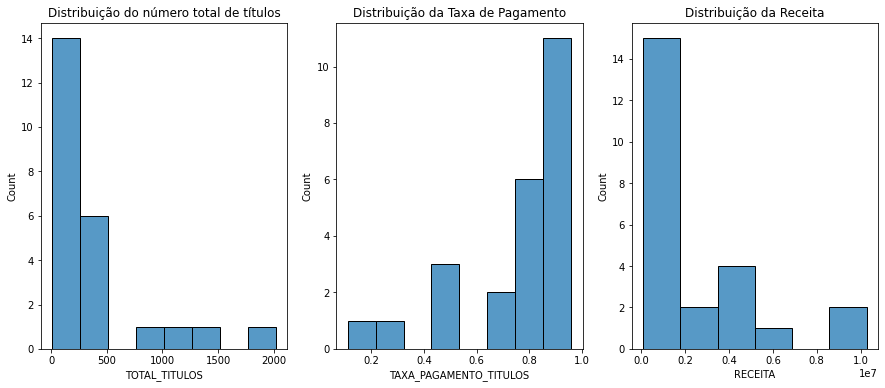

In [17]:
# gerando graficos para analisar as distribuções dos indicadores dos cedentes
plt.figure(figsize=(15,6))

plt.subplot(1 , 3 , 1)
sns.histplot(data=df_indicadores_cedentes, x='TOTAL_TITULOS', )
plt.title('Distribuição do número total de títulos')

plt.subplot(1 , 3 , 2)
sns.histplot(data=df_indicadores_cedentes, x='TAXA_PAGAMENTO_TITULOS')
plt.title('Distribuição da Taxa de Pagamento')

plt.subplot(1 , 3 , 3)
sns.histplot(data=df_indicadores_cedentes, x='RECEITA')
plt.title('Distribuição da Receita')
plt.show()


Notamos que muitos clientes cedentes tem um número menor de títulos, ao passo que grande parte deles apresentam uma taxa de pagamento mais alta.

Olhando para a receita, temos um grupo bem concentrado com receitas menores em relação aos demais.

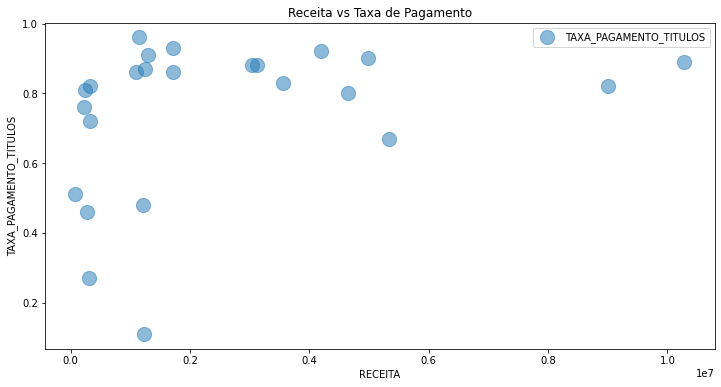

In [18]:
# vamos analisar as correlações entre os indicadores
# grafico de pontos flutuantes da Receita vs taxa de pagamento 
plt.figure(figsize=(12,6))
plt.scatter(x='RECEITA',y = 'TAXA_PAGAMENTO_TITULOS' ,
            data = df_indicadores_cedentes, s = 200, alpha = 0.5)
plt.xlabel('RECEITA')
plt.ylabel('TAXA_PAGAMENTO_TITULOS') 

plt.title('Receita vs Taxa de Pagamento')
plt.legend()
plt.show()

Este gráfico mostra maior concentração de clientes com receitas menores e que pagam os títulos em dia com mais frequencia.

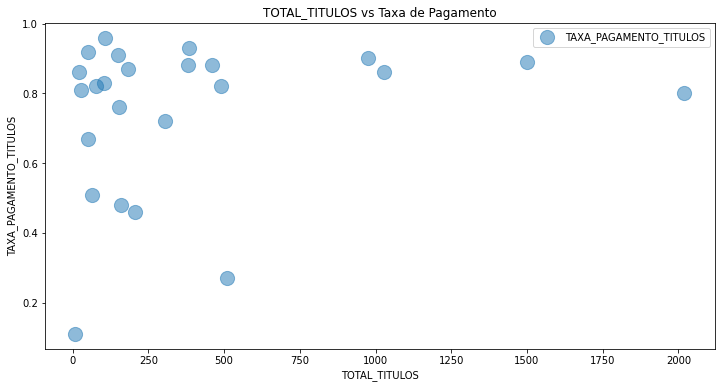

In [19]:
# grafico de pontos flutuantes do total de titulos vs taxa de pagamento
plt.figure(figsize=(12,6))
plt.scatter(x='TOTAL_TITULOS',y = 'TAXA_PAGAMENTO_TITULOS' ,
            data = df_indicadores_cedentes, s = 200, alpha = 0.5)
plt.xlabel('TOTAL_TITULOS')
plt.ylabel('TAXA_PAGAMENTO_TITULOS') 

plt.title('TOTAL_TITULOS vs Taxa de Pagamento')
plt.legend()
plt.show()

Novamente temos um comportamento semelhante, com clientes mais concentrados na área de taxa de pagamento alta e menos títulos.

O perfil de clientes com altas receitas geradas e altas taxas de pagamento é mais restrito, ou seja, poucos clientes se encaixam nesse perfil.

# Segmentação de clientes cedentes

Para a realização da segmentação dos clientes optamos pelo método K-means. 

O método K-means agrupa dados que compartilham características importantes e parecidas. Basicamente, o algoritmo encontra uma boa solução para o processo de clusterização em que os dados do grupo são mais semelhantes entre si, do que comparados com outro grupo.

Optamos pelo k-means por ele ser escalável e eficiente. Além disso, a literatura mostra que frequentemente, após as iterações do algoritmo, o mesmo termina num local ótimo, ou seja, encontra uma solução ótima para o problema de clusterização

A segmentação foi realizada com base nos indicadores de Taxa de Pagamento e Receitas


## Determinando o número ideal de clusters
A técnica K-means necessita que o numero *K* de clusters seja informado com antecedencia.

Este valor pode ser obtido avaliando e minimizando as distâncias entre os cluesters com o método Elbow.

Resumidamente, está técnica verifica a soma das distâncias entre os clusters conforme aumentamos o número de clusters analisados. 

Quando há uma estabilização das distâncias, mesmo aumentando o número de clusters, temos o indicativo do número ótimo de clusters. 

In [20]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X_treino_segmentacao = df_indicadores_cedentes[['RECEITA' , 'TAXA_PAGAMENTO_TITULOS']].iloc[: , :].values
inertia = []          # Lista para Soma das distâncias quadráticas intra cluster.

# treinamento do modelo com abordagem não-supervisionada - otimizando o numero ideal de clusters
# verificando a metrica de soma das distancias dos clusters para n clusters (1 até 11)
for n in range(1 , 11):
    modelo_kmeans = (KMeans(n_clusters = n))
    modelo_kmeans.fit(X_treino_segmentacao)
    inertia.append(modelo_kmeans.inertia_)

C:\Users\PICHAU\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


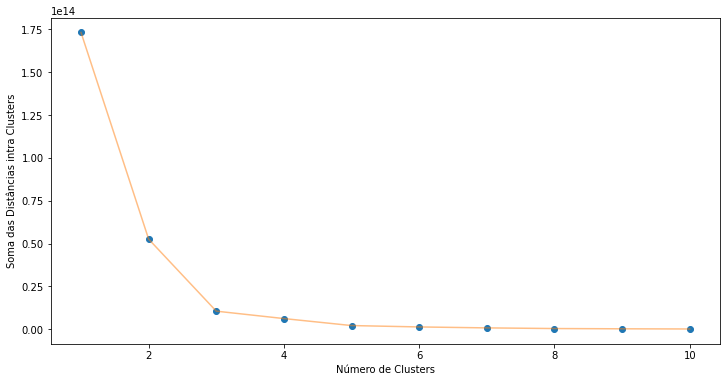

In [21]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters')
plt.ylabel('Soma das Distâncias intra Clusters')
plt.show()

É importante notar que a partir de 3 cluesters, a métrica de distância entre os clusters começou a convergir para o valor ótimo de clusters.

Dito isso, temos que o número de segmentos de clientes é 3.

### Testando do modelo

In [27]:
# 3 clusters de clientes cedentes
modelo_kmeans = (KMeans(n_clusters = 3))
modelo_kmeans.fit(X_treino_segmentacao)

# testando o modelo com os parametros determinados
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(n_clusters=3, n_jobs=None, precompute_distances='auto')

## Gráfico dos clusters de clientes cedentes

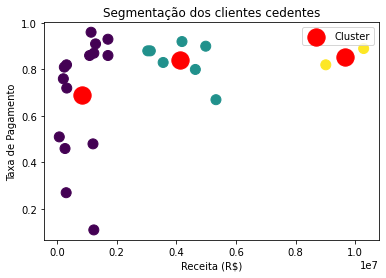

In [28]:
plt.scatter(X_treino_segmentacao[:, 0], X_treino_segmentacao[:,1], s = 100, c = modelo_kmeans.labels_)
plt.scatter(modelo_kmeans.cluster_centers_[:, 0], modelo_kmeans.cluster_centers_[:, 1], s = 300, c = 'red',label = 'Cluster')
plt.title('Segmentação dos clientes cedentes')
plt.xlabel('Receita (R$)')
plt.ylabel('Taxa de Pagamento')
plt.legend()

plt.show()

## Entendendo os perfis dos clientes cedentes

Vemos os agrupamentos de clientes nas regiões dos clusters inferidos pelo algoritmo K-means.

Analisando os clusters apresentados pelo método K-means, no **cluster 0** temos clientes com perfil de taxas de pagamento próximas da média de 74,7% e com receitas menores.

No outro segmento, tido como **cluster 1**, temos clientes com o perfil de taxas de pagamento um pouco acima da média de 74,7% e receitas maiores.

Por fim, no **cluster 2** temos um segmento de clientes taxas de pagamento acima da média e receitas altas.

## Incluindo cluster segmantado no DataFrame de indicadores dos cedentes 

In [29]:
df_indicadores_cedentes["clusters"] = modelo_kmeans.labels_
df_indicadores_cedentes.head()

,CEDENTE,ATRASO,EM_DIA,TOTAL_TITULOS,TAXA_PAGAMENTO_TITULOS,RECEITA,clusters
0,Cedente 1,166,1335,1501,0.89,10280760.20,2
1,Cedente 10,4,46,50,0.92,4191119.98,1
2,Cedente 11,18,86,104,0.83,3559953.22,1
3,Cedente 12,4,103,107,0.96,1143889.00,0
4,Cedente 13,17,35,52,0.67,5329983.11,1


In [30]:
df_indicadores_cedentes.sort_values(by='clusters')

,CEDENTE,ATRASO,EM_DIA,TOTAL_TITULOS,TAXA_PAGAMENTO_TITULOS,RECEITA,clusters
21,Cedente 7,3,19,22,0.86,1710127.21,0
20,Cedente 6,14,63,77,0.82,321183.80,0
3,Cedente 12,4,103,107,0.96,1143889.00,0
19,Cedente 5,28,357,385,0.93,1709214.75,0
5,Cedente 14,24,157,181,0.87,1236814.87,0
6,Cedente 15,83,77,160,0.48,1207862.29,0
7,Cedente 16,5,21,26,0.81,247306.28,0
8,Cedente 17,147,882,1029,0.86,1094160.68,0
9,Cedente 18,31,32,63,0.51,78572.09,0
18,Cedente 4,8,1,9,0.11,1235611.34,0


Acima temos a lista de cedentes agrupados pelos segmentos gerados com o algoritmo K-means.